In [1]:
import xarray as xr

import glob
import os
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

# from dask.distributed import Client, LocalCluster

## Open Cloud Height xarray dataset

In [2]:
zarr_path = '/storage/GOES/orthorectified/Fog2022_withtime.zarr'
ds = xr.open_dataset(
    zarr_path,
    chunks={'time': 40785, 'latitude': 3, 'longitude': 3},
    engine='zarr'
)
# When we pass in a chunks argument, the dataset opened will be filled with Dask arrays

/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "latitude" starting at index 3. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 3. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [3]:
# Longitudes and Latitudes for all the field locations on San Juan Islands
mtdallas = (48.53, -123.13)
cattlepoint = (48.46, -122.96)
falsebay = (48.48, -123.06)
fhl = (48.55, -123.01)

In [4]:
falsebay_timeseries = ds['Height'].sel(latitude = falsebay[0], longitude = falsebay[1], method='nearest')
falsebay_timeseries

<xarray.DataArray 'Height' (time: 40785)>
dask.array<getitem, shape=(40785,), dtype=float32, chunksize=(40785,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 48.48
    longitude  float64 -123.1
  * time       (time) datetime64[ns] 2022-04-30T17:01:17 ... 2022-09-30T16:51:17
Attributes:
    coordinates:   dem_px_angle_y dem_px_angle_x
    grid_mapping:  spatial_ref

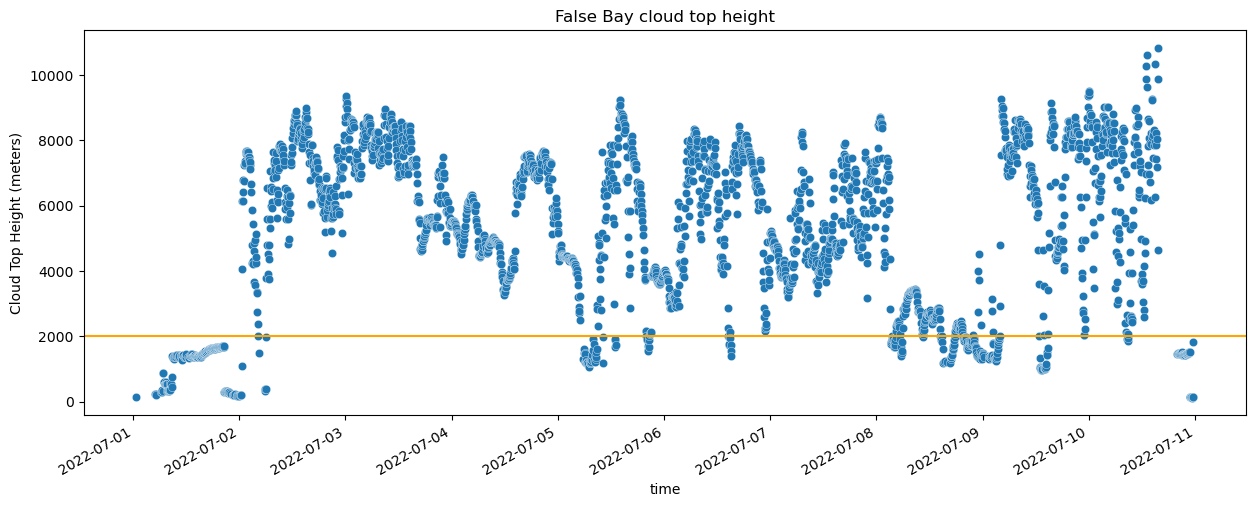

In [6]:
falsebay_timeseries.sel(time = slice('July 1, 2022', 'July 10, 2022')).plot.scatter('time', figsize=(15,5), linewidths=0.25)
plt.title('False Bay cloud top height')
plt.ylabel('Cloud Top Height (meters)')
plt.axhline(2000, color='orange') # 2000 meters is the chosen threshold for low cloud and fog

In [13]:
cattlepoint_timeseries = ds['Height'].sel(latitude = cattlepoint[0], longitude = cattlepoint[1], method='nearest')

## Open computer vision fog prediction pandas dataframe

In [2]:
df = pd.read_csv('image_classification_output/FalseBay_predicted_time_df.csv', index_col = 0)
df

,Time,Predicted label
0,2022-05-01 06:00:01,1
1,2022-05-01 06:30:01,1
2,2022-05-01 07:00:01,1
3,2022-05-01 07:30:01,1
4,2022-05-01 08:00:01,1
...,...,...
2187,2022-07-18 07:30:01,0
2188,2022-07-18 08:00:01,0
2189,2022-07-18 08:30:01,0
2190,2022-07-18 09:00:01,0


In [3]:
# Convert the time values which are currently strings to datetime
df['Time'] = pd.to_datetime(df['Time'])
type(df['Time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [4]:
fog_df = df.set_index('Time') # can only slice time if time is index

In [5]:
fog_df

,Predicted label
Time,
2022-05-01 06:00:01,1
2022-05-01 06:30:01,1
2022-05-01 07:00:01,1
2022-05-01 07:30:01,1
2022-05-01 08:00:01,1
...,...
2022-07-18 07:30:01,0
2022-07-18 08:00:01,0
2022-07-18 08:30:01,0


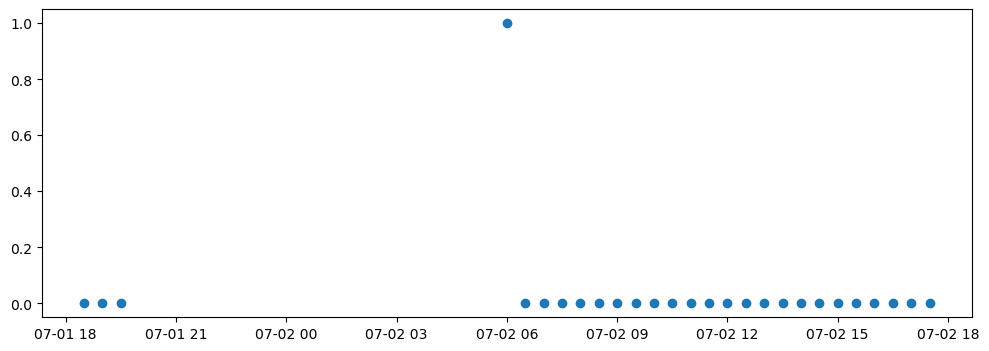

In [12]:
plt.figure(figsize=(12,4))
plt.scatter(fog_df['2022-07-01 18:00:02': '2022-07-02 18:00:00'].index, fog_df['2022-07-01 18:00:02': '2022-07-02 18:00:00']["Predicted label"])
# plt.scatter(time_df[10:30].index, time_df[10:30]["Predicted label"])

## Compare

### Merge the Cloud Height DataArray and Fog Dataframe into one dataframe with the same time column/index

In [14]:
# # Convert Cloud Height into pandas dataframe
# cattlepoint_height_df = cattlepoint_timeseries.to_dataframe()
# # Save in a csv file because converting to dataframe takes a while
# cattlepoint_height_df.to_csv('cattlepoint_cloudheight_df.csv')

### False Bay

In [6]:
''' When loading the dataframe of Cloud Height from in a csv file,
we have to set the time column as index in order to merge it later with the fog classification along the time axis.
datetime after read out from csv are usually strings, so we have to convert them back to datetime objects
'''
fb_height_df = pd.read_csv('cloud_height_timeseries/falsebay_cloudheight_df.csv', index_col='time', parse_dates=True)
print(type(fb_height_df.index[0]))
fb_height_df 

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,latitude,longitude,Height
time,,,
2022-04-30 17:01:17,48.476114,-123.056412,770.63934
2022-04-30 17:06:17,48.476114,-123.056412,698.91650
2022-04-30 17:11:17,48.476114,-123.056412,NaN
2022-04-30 17:16:17,48.476114,-123.056412,NaN
2022-04-30 17:21:17,48.476114,-123.056412,NaN
...,...,...,...
2022-09-30 16:31:17,48.476114,-123.056412,1886.46410
2022-09-30 16:36:17,48.476114,-123.056412,1928.58230
2022-09-30 16:41:17,48.476114,-123.056412,NaN


In [7]:
fog_df

,Predicted label
Time,
2022-05-01 06:00:01,1
2022-05-01 06:30:01,1
2022-05-01 07:00:01,1
2022-05-01 07:30:01,1
2022-05-01 08:00:01,1
...,...
2022-07-18 07:30:01,0
2022-07-18 08:00:01,0
2022-07-18 08:30:01,0


In [8]:
fb = pd.concat([fb_height_df, fog_df], axis=1)

In [9]:
fb.index

DatetimeIndex(['2022-04-30 17:01:17', '2022-04-30 17:06:17',
               '2022-04-30 17:11:17', '2022-04-30 17:16:17',
               '2022-04-30 17:21:17', '2022-04-30 17:26:17',
               '2022-04-30 17:31:17', '2022-04-30 17:36:17',
               '2022-04-30 17:41:17', '2022-04-30 17:46:17',
               ...
               '2022-09-30 16:06:17', '2022-09-30 16:11:17',
               '2022-09-30 16:16:17', '2022-09-30 16:21:17',
               '2022-09-30 16:26:17', '2022-09-30 16:31:17',
               '2022-09-30 16:36:17', '2022-09-30 16:41:17',
               '2022-09-30 16:46:17', '2022-09-30 16:51:17'],
              dtype='datetime64[ns]', length=42977, freq=None)

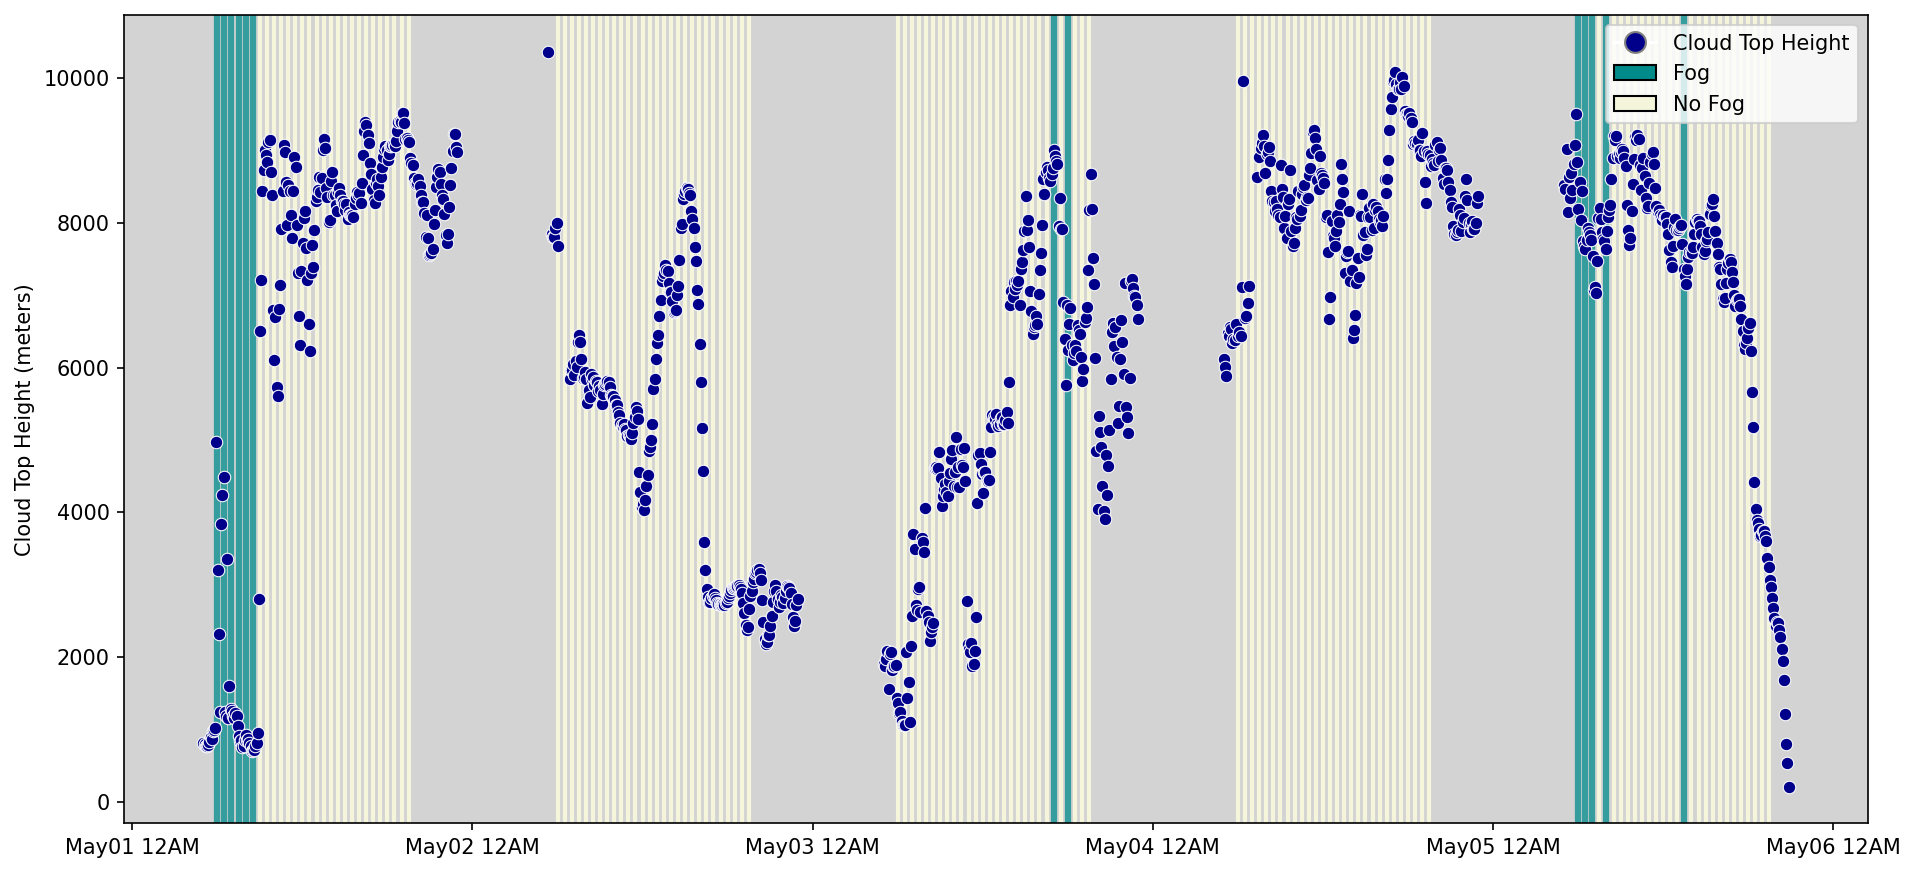

In [14]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig, ax1 = plt.subplots(figsize = (15,7), dpi=150) # change dpi from default 100 to 150 to increase resolution
df1 = fb['2022-05-01 05:00:00': '2022-05-05 21:00:00']

for i in range(len(df1)):
	if df1["Predicted label"][i] == 0:
			no_fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='beige', alpha=1, linewidth=2, label='no fog')

	elif df1["Predicted label"][i] == 1:
			fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='darkcyan', alpha=0.75, linewidth=3, label='fog')


ax1.scatter(df1.index, df1["Height"], color='darkblue', linewidths=0.5, edgecolor='white', label="Cloud Top Height") # Cloud Height points
ax1.set_ylabel("Cloud Top Height (meters)")
ax1.set_facecolor('lightgrey') # background color

# Define the date format
date_form = DateFormatter("%h%d %I%p")
ax1.xaxis.set_major_formatter(date_form)

# Add custom legend (doc: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
legend_elements = [	Line2D([0], [0], marker='o', color='w', label='Cloud Top Height', markerfacecolor='darkblue', markeredgecolor='grey', markersize=10),
					Patch(facecolor='darkcyan', edgecolor='black', label='Fog'),
					Patch(facecolor='beige', edgecolor='black', label='No Fog')
					]
ax1.legend(handles=legend_elements)
# ax1.tick_params(axis='x', labelrotation=90)

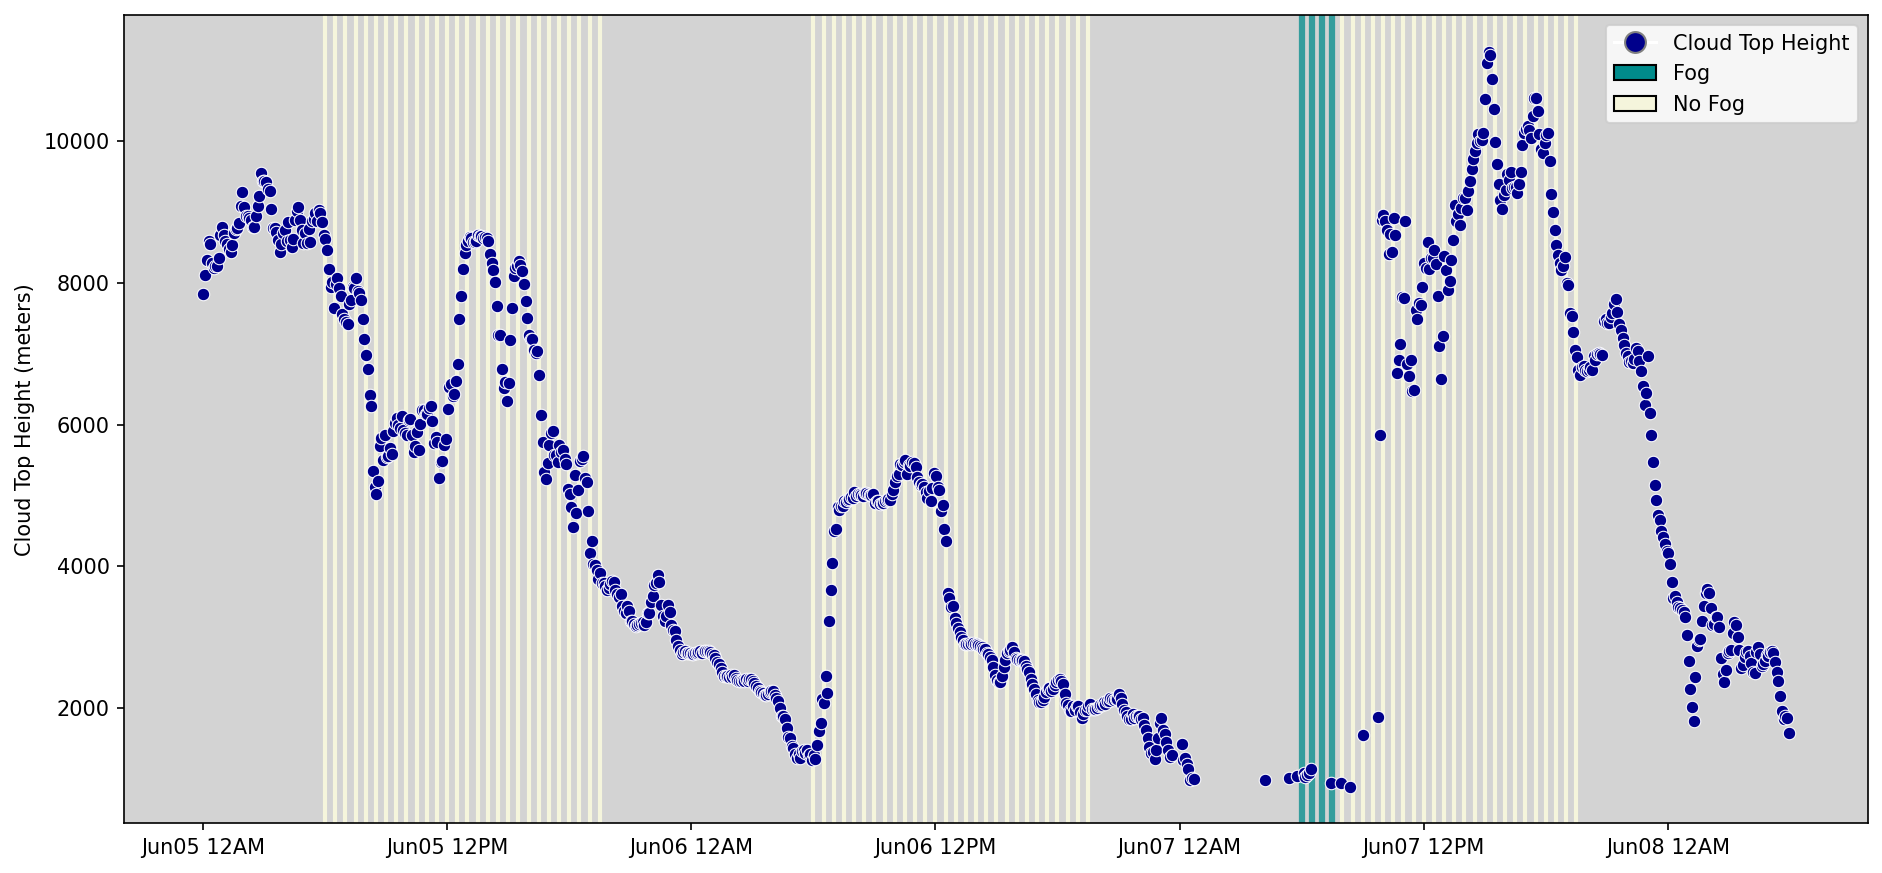

In [15]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig, ax1 = plt.subplots(figsize = (15,7), dpi=150) # change dpi from default 100 to 150 to increase resolution
df1 = fb['2022-06-05 00:00:00': '2022-06-08 06:00:00']

for i in range(len(df1)):
	if df1["Predicted label"][i] == 0:
			no_fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='beige', alpha=1, linewidth=2, label='no fog')

	elif df1["Predicted label"][i] == 1:
			fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='darkcyan', alpha=0.75, linewidth=3, label='fog')


ax1.scatter(df1.index, df1["Height"], color='darkblue', linewidths=0.5, edgecolor='white', label="Cloud Top Height") # Cloud Height points
ax1.set_ylabel("Cloud Top Height (meters)")
ax1.set_facecolor('lightgrey') # background color

# Define the date format
date_form = DateFormatter("%h%d %I%p")
ax1.xaxis.set_major_formatter(date_form)

# Add custom legend (doc: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
legend_elements = [	Line2D([0], [0], marker='o', color='w', label='Cloud Top Height', markerfacecolor='darkblue', markeredgecolor='grey', markersize=10),
					Patch(facecolor='darkcyan', edgecolor='black', label='Fog'),
					Patch(facecolor='beige', edgecolor='black', label='No Fog')
					]
ax1.legend(handles=legend_elements)
# ax1.tick_params(axis='x', labelrotation=90)

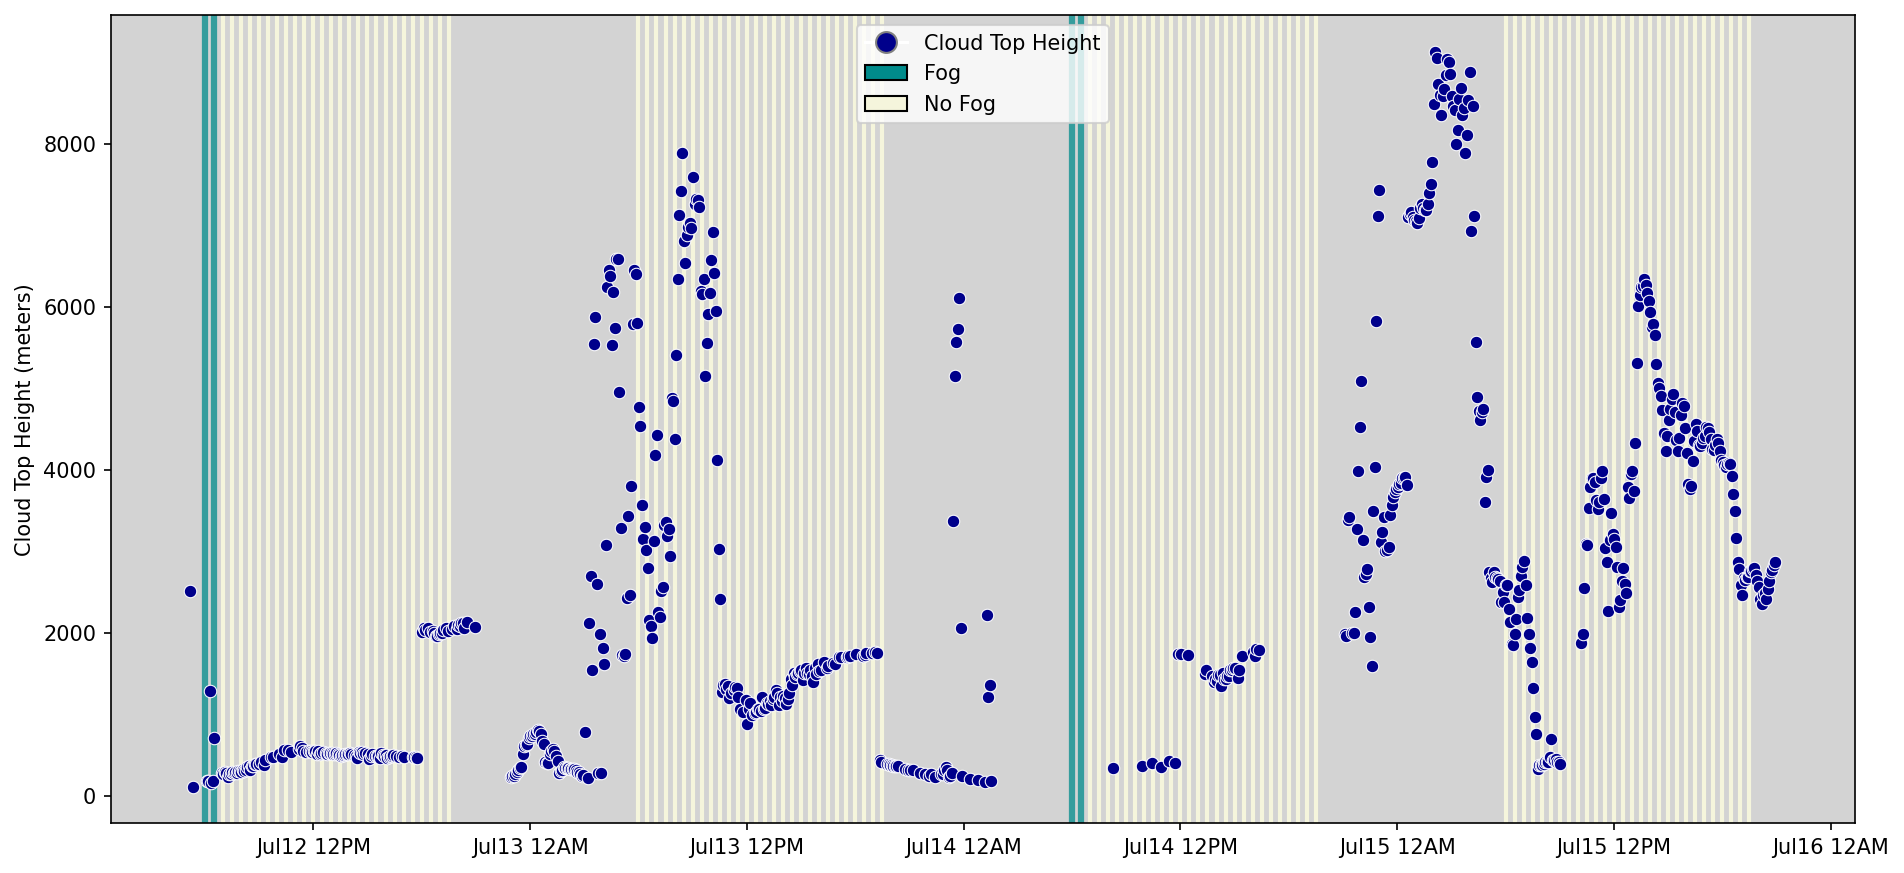

In [16]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig, ax1 = plt.subplots(figsize = (15,7), dpi=150) # change dpi from default 100 to 150 to increase resolution
df1 = fb['2022-07-12 05:00:00': '2022-07-15 21:00:00']

for i in range(len(df1)):
	if df1["Predicted label"][i] == 0:
			no_fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='beige', alpha=1, linewidth=2, label='no fog')

	elif df1["Predicted label"][i] == 1:
			fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='darkcyan', alpha=0.75, linewidth=3, label='fog')


ax1.scatter(df1.index, df1["Height"], color='darkblue', linewidths=0.5, edgecolor='white', label="Cloud Top Height") # Cloud Height points
ax1.set_ylabel("Cloud Top Height (meters)")
ax1.set_facecolor('lightgrey') # background color

# Define the date format
date_form = DateFormatter("%h%d %I%p")
ax1.xaxis.set_major_formatter(date_form)

# Add custom legend (doc: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
legend_elements = [	Line2D([0], [0], marker='o', color='w', label='Cloud Top Height', markerfacecolor='darkblue', markeredgecolor='grey', markersize=10),
					Patch(facecolor='darkcyan', edgecolor='black', label='Fog'),
					Patch(facecolor='beige', edgecolor='black', label='No Fog')
					]
ax1.legend(handles=legend_elements)
# ax1.tick_params(axis='x', labelrotation=90)

Text(0.5, 1.0, 'GOES-derived Cloud Top Height and camera-derived Fog detection\nat False Bay\nMay 01 - July 18 2022')

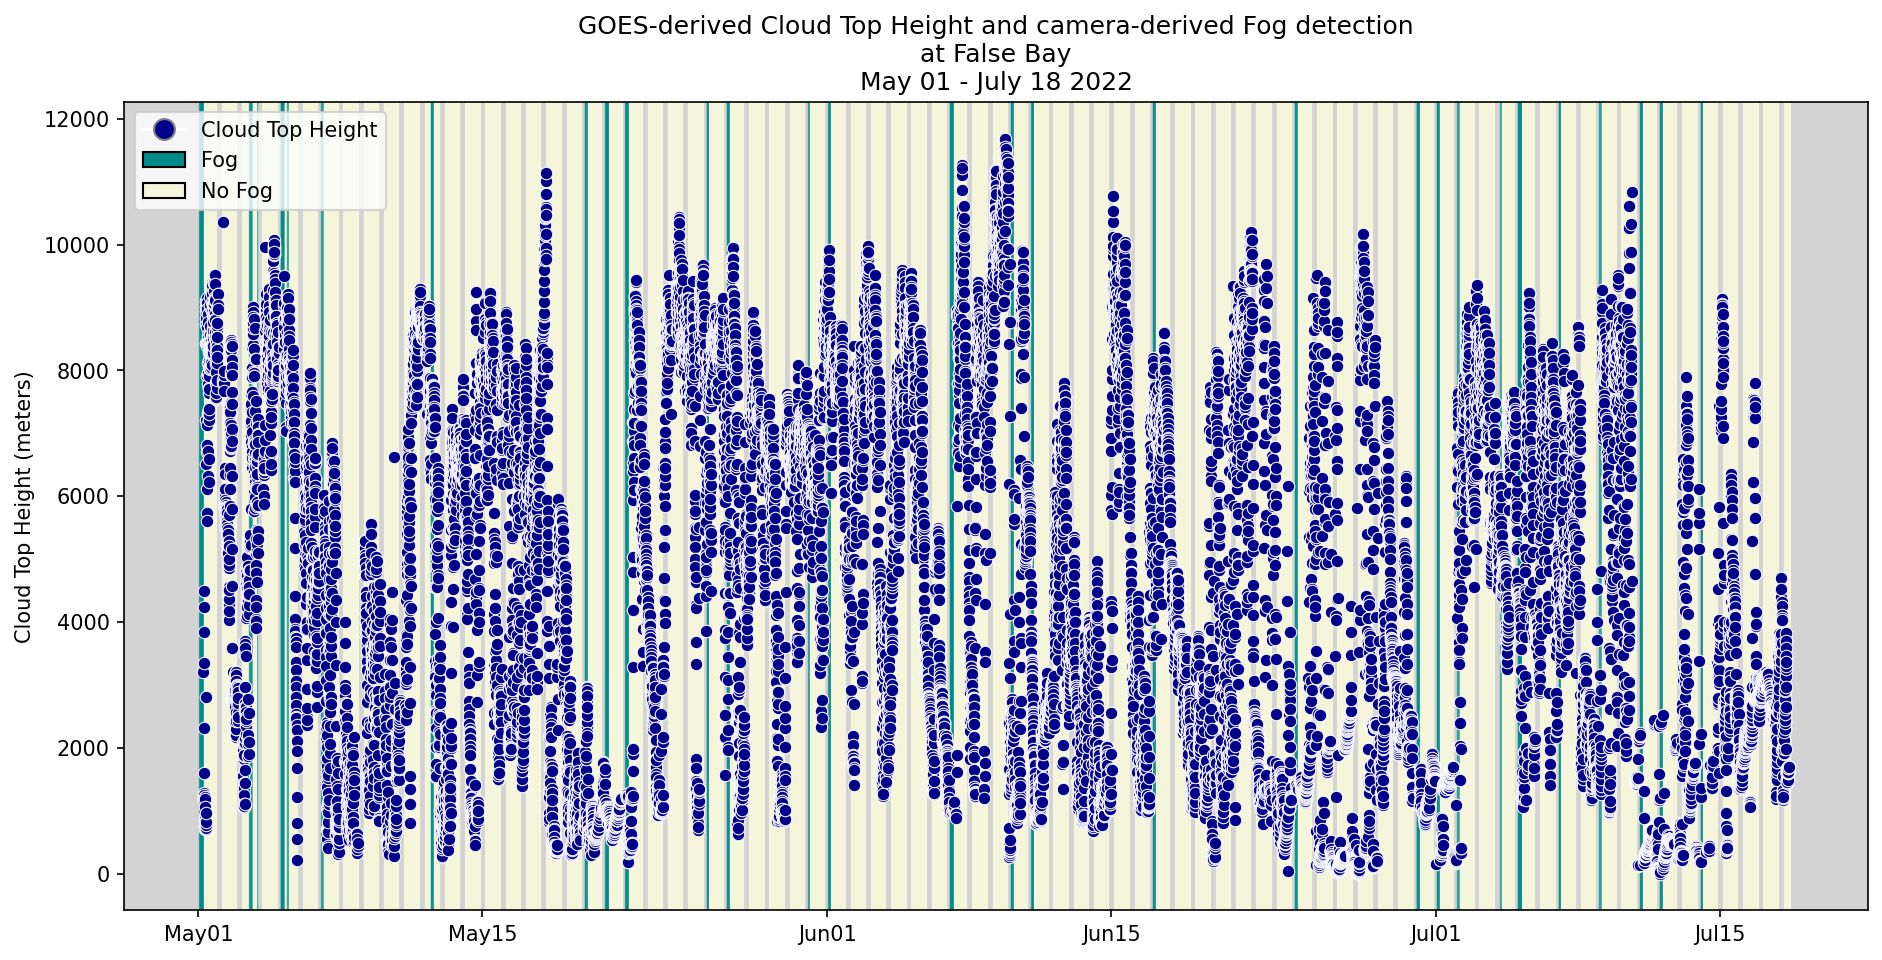

In [17]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig, ax1 = plt.subplots(figsize = (15,7), dpi=150) # change dpi from default 100 to 150 to increase resolution
df1 = fb[fog_df.index[0]: fog_df.index[-1]]

for i in range(len(df1)):
	if df1["Predicted label"][i] == 0:
			no_fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='beige', alpha=1, linewidth=2, label='no fog')

	elif df1["Predicted label"][i] == 1:
			fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='darkcyan', alpha=0.75, linewidth=4, label='fog')


ax1.scatter(df1.index, df1["Height"], color='darkblue', linewidths=0.5, edgecolor='white', label="Cloud Top Height") # Cloud Height points
ax1.set_ylabel("Cloud Top Height (meters)")
ax1.set_facecolor('lightgrey') # background color

# Define the date format
date_form = DateFormatter("%h%d")
ax1.xaxis.set_major_formatter(date_form)

# Add custom legend (doc: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
legend_elements = [	Line2D([0], [0], marker='o', color='w', label='Cloud Top Height', markerfacecolor='darkblue', markeredgecolor='grey', markersize=10),
					Patch(facecolor='darkcyan', edgecolor='black', label='Fog'),
					Patch(facecolor='beige', edgecolor='black', label='No Fog')
					]
ax1.legend(handles=legend_elements)
# ax1.tick_params(axis='x', labelrotation=90)
ax1.set_title("GOES-derived Cloud Top Height and camera-derived Fog detection\nat False Bay\nMay 01 - July 18 2022")

### Cattle Point

In [32]:
cp_height_df = pd.read_csv('cloud_height_timeseries/cattlepoint_cloudheight_df.csv', index_col='time', parse_dates=True)

In [33]:
cp = pd.concat([cp_height_df, fog_df], axis=1)

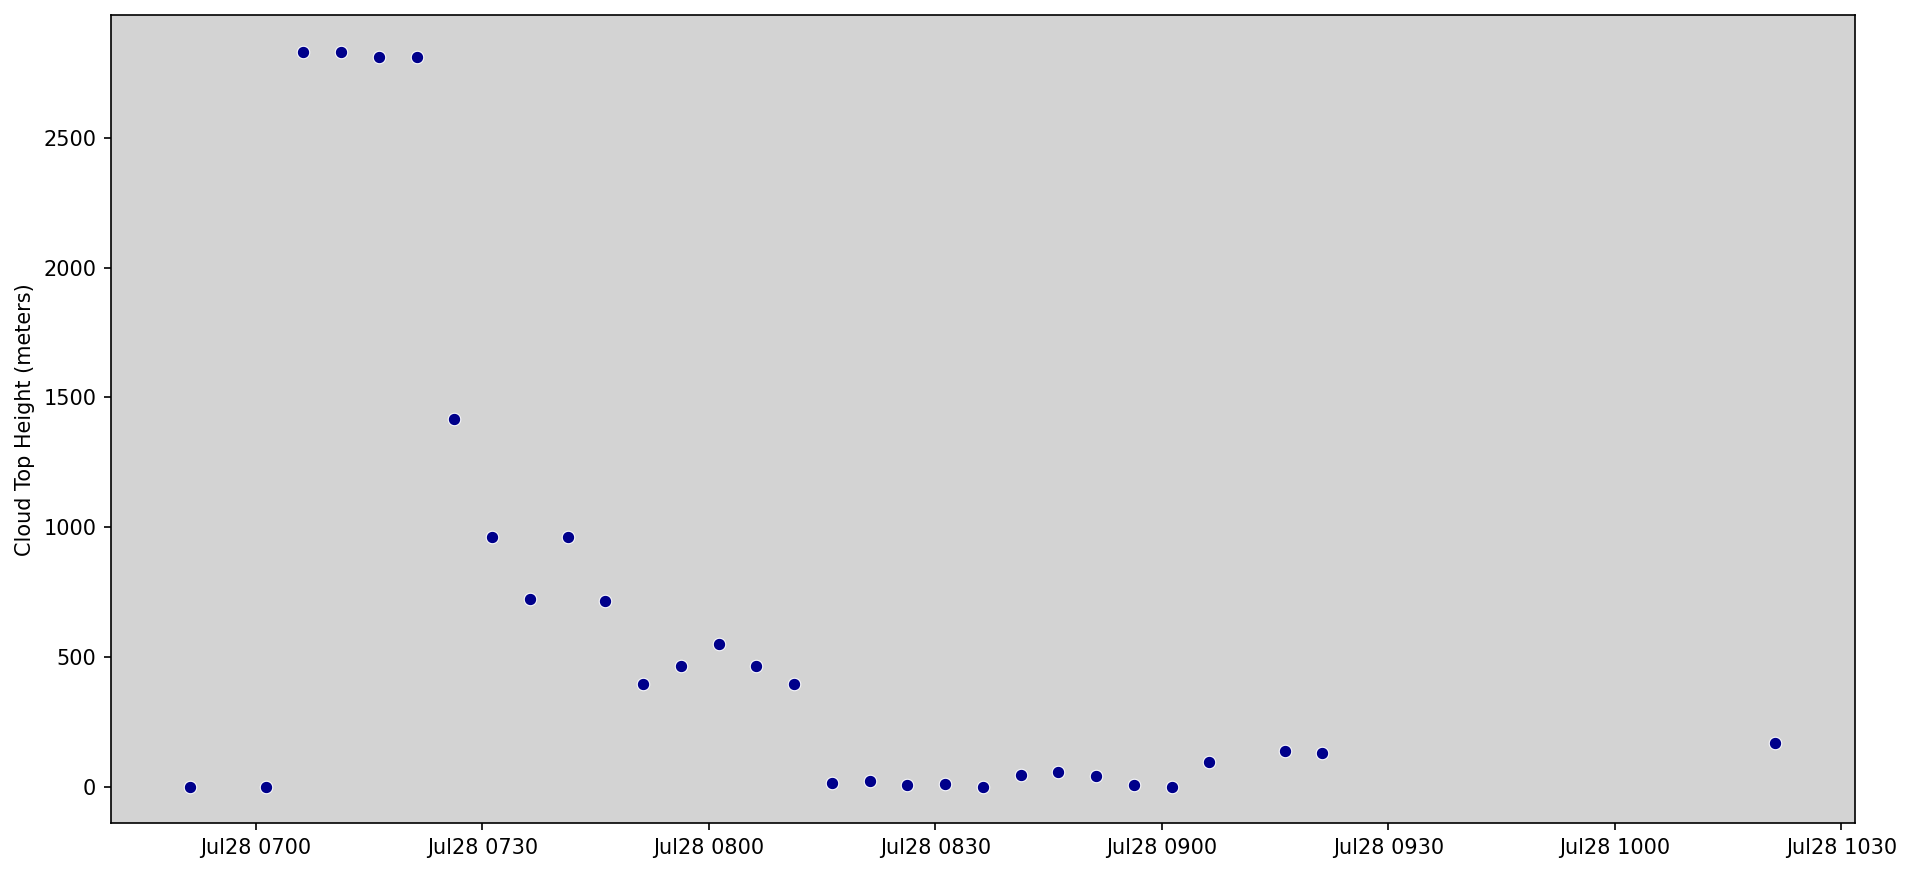

In [35]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig, ax1 = plt.subplots(figsize = (15,7), dpi=150) # change dpi from default 100 to 150 to increase resolution

df1 = cp['2022-07-28 06:00:00': '2022-07-28 10:30:00']
ax1.scatter(df1.index, df1["Height"], color='darkblue', linewidths=0.5, edgecolor='white', label="Cloud Top Height") # Cloud Height points
ax1.set_ylabel("Cloud Top Height (meters)")
ax1.set_facecolor('lightgrey') # background color

# for i in range(len(df1)):
# 	if df1["Predicted label"][i] == 0:
# 			no_fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='beige', alpha=1, linewidth=2, label='no fog')

# 	elif df1["Predicted label"][i] == 1:
# 			fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='darkcyan', alpha=0.75, linewidth=1.8, label='fog')

# Define the date format
date_form = DateFormatter("%h%d %H%M")
ax1.xaxis.set_major_formatter(date_form)

# Add custom legend (doc: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
# legend_elements = [	Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='darkblue', markeredgecolor='grey', markersize=10),
# 					Patch(facecolor='darkcyan', edgecolor='black', label='Fog'),
# 					Patch(facecolor='beige', edgecolor='black', label='No Fog')
# 					]
# ax1.legend(handles=legend_elements)
# ax1.tick_params(axis='x', labelrotation=90)

## Cloud Top Height map at one particular timestamp

### Investigating July 12 2022 at 12pm Pacific Time

In [31]:
from plot_shoreline import plot_from_globe_shoreline

Successfully run plot_shoreline.py


In [32]:
image_folder = '/storage/GOES/orthorectified/Fog2022_withtime/'
files = glob.glob(os.path.join(image_folder, "*s20221931901*.nc")) # July 12 is the 193rd day of the year 2022. 12pm Pacific Time is the 19th hour UTC Time.
files # a LIST of one file

['/storage/GOES/orthorectified/Fog2022_withtime/OR_ABI-L2-ACHAC-M6_G17_s20221931901177_e20221931903550_c20221931906183_o.nc']

In [13]:
ds = xr.open_dataset(files[0]) # need to specify [0] to get the file from the list, otherwise will have error "did not find a match in any of xarray's currently installed IO backends..."
ds

<xarray.Dataset>
Dimensions:      (longitude: 284, latitude: 284, time: 1)
Coordinates:
  * longitude    (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0
  * latitude     (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * time         (time) datetime64[ns] 2022-07-12T19:01:17
Data variables:
    spatial_ref  int64 ...
    HT           (time, latitude, longitude) float32 ...

In [35]:
bounds = ds.rio.bounds()
shoreline = plot_from_globe_shoreline(bounds)

Text(0.5, 1.0, 'Cloud Top Height\n 2022-07-12 12pm Pacific Time')

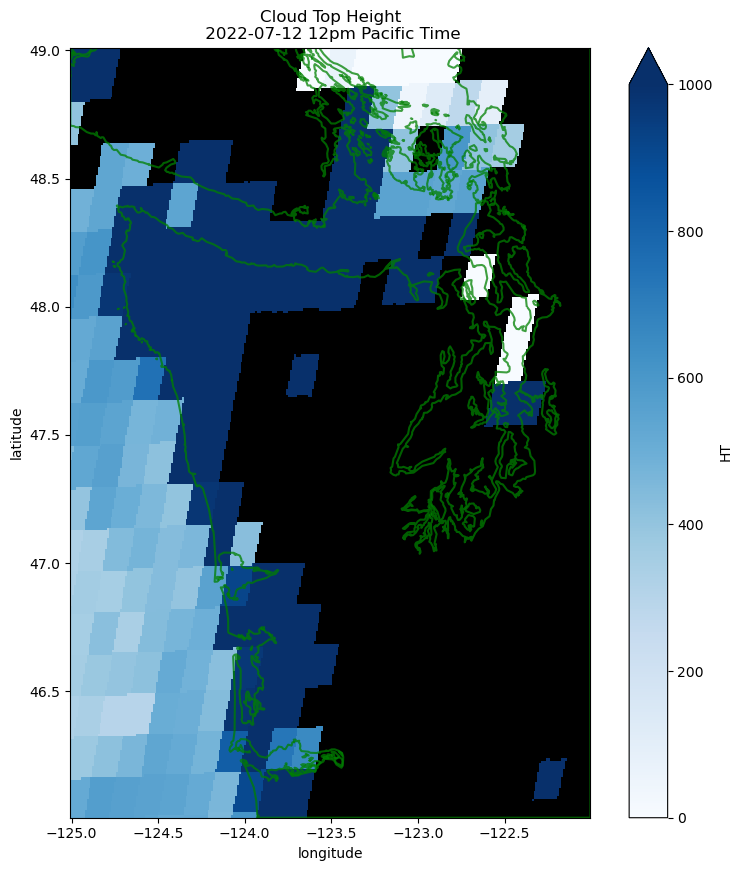

In [34]:
fig, ax = plt.subplots(figsize = (10,10)) # to adjust size/resolution, increase/decrease figsize, but don't adjust dpi variable for this -- it makes the shoreline thicker

ds['HT'].plot(ax = ax, cmap = 'Blues', vmax = 1000) 
# vmax=2000 means any cloud height above 1000 meters is represented as the same dark blue hue.
# we do this to look closely at the low cloud height values (around 500 meters at July 12 12pm)
shoreline.plot(ax=ax, color = "green", alpha = 0.75)
ax.set_facecolor('black')
ax.set_title('Cloud Top Height\n 2022-07-12 12pm Pacific Time')

### July 28 interesting foggy morning in Cattle Point

In [33]:
image_folder = '/storage/GOES/orthorectified/Fog2022_withtime/'
files = glob.glob(os.path.join(image_folder, "*s20222091601*.nc")) # July 28 is the 209th day of the year 2022. 9am Pacific Time is the 16th hour UTC Time.
ds_1601 = xr.open_dataset(files[0])
files # a LIST of one file

['/storage/GOES/orthorectified/Fog2022_withtime/OR_ABI-L2-ACHAC-M6_G17_s20222091601176_e20222091603549_c20222091606400_o.nc']

Text(0.5, 1.0, 'Cloud Top Height\n 2022-07-28 9:00am Pacific Time')

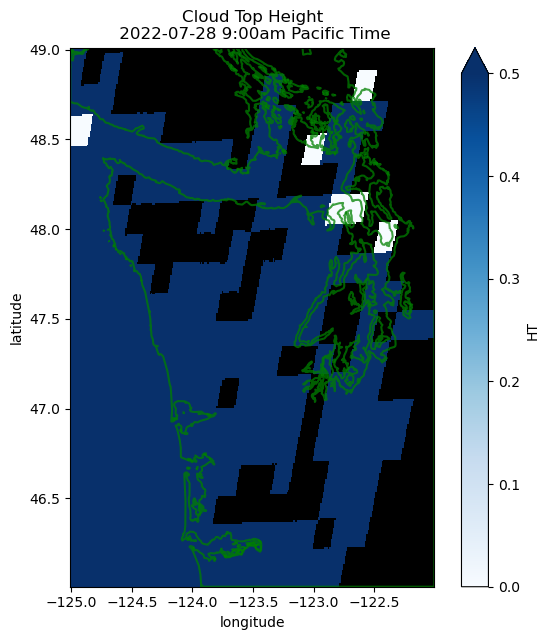

In [36]:
fig, ax = plt.subplots(figsize = (7,7)) # to adjust size/resolution, increase/decrease figsize, but don't adjust dpi variable for this -- it makes the shoreline thicker

ds_1601['HT'].plot(ax = ax, cmap = 'Blues', vmax = 0.5) 
# vmax=2000 means any cloud height above 1000 meters is represented as the same dark blue hue.
# we do this to look closely at the low cloud height values (around 500 meters at July 12 12pm)
shoreline.plot(ax=ax, color = "green", alpha = 0.75)
ax.set_facecolor('black')
ax.set_title('Cloud Top Height\n 2022-07-28 9:00am Pacific Time')

In [37]:
files = glob.glob(os.path.join(image_folder, "*s20222091631*.nc")) # July 28 is the 209th day of the year 2022. 9am Pacific Time is the 16th hour UTC Time.
ds_1631 = xr.open_dataset(files[0])
files # a LIST of one file

['/storage/GOES/orthorectified/Fog2022_withtime/OR_ABI-L2-ACHAC-M6_G17_s20222091631176_e20222091633549_c20222091636516_o.nc']

Text(0.5, 1.0, 'Cloud Top Height\n 2022-07-28 9:30am Pacific Time')

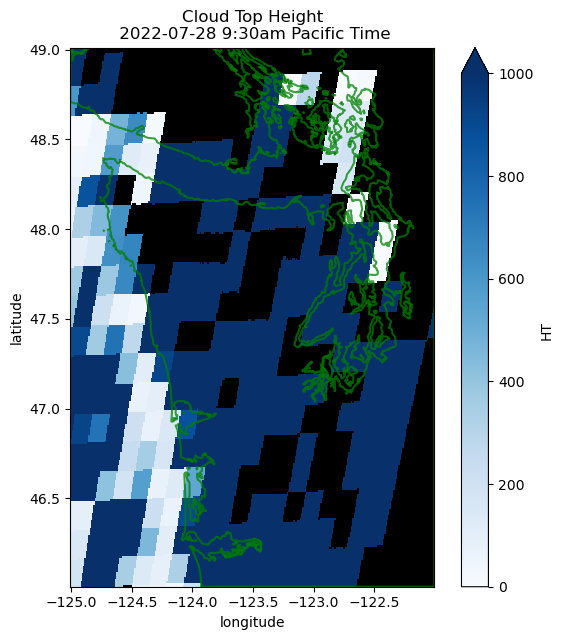

In [38]:
fig, ax = plt.subplots(figsize = (7,7)) # to adjust size/resolution, increase/decrease figsize, but don't adjust dpi variable for this -- it makes the shoreline thicker

ds_1631['HT'].plot(ax = ax, cmap = 'Blues', vmax = 1000) 
# vmax=2000 means any cloud height above 1000 meters is represented as the same dark blue hue.
# we do this to look closely at the low cloud height values (around 500 meters at July 12 12pm)
shoreline.plot(ax=ax, color = "green", alpha = 0.75)
ax.set_facecolor('black')
ax.set_title('Cloud Top Height\n 2022-07-28 9:30am Pacific Time')

Text(0.5, 1.0, 'Cloud Top Height\n 2022-07-28 10:00am Pacific Time')

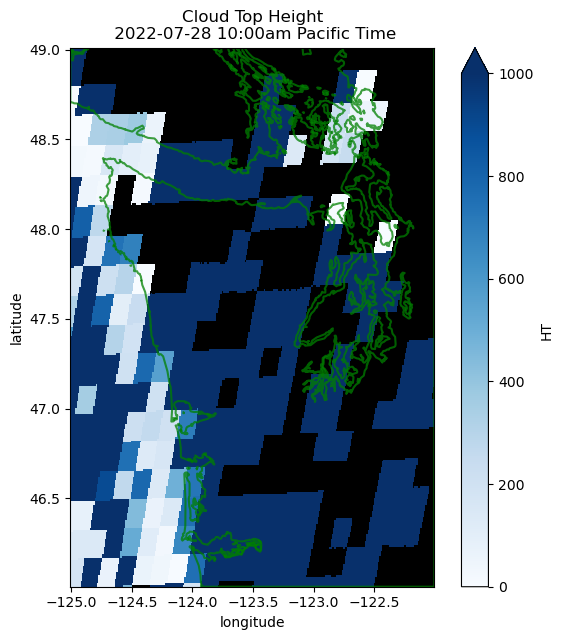

In [42]:
files = glob.glob(os.path.join(image_folder, "*s20222091701*.nc")) # July 28 is the 209th day of the year 2022. 9am Pacific Time is the 16th hour UTC Time.
ds_1701 = xr.open_dataset(files[0])
files # a LIST of one file

fig, ax = plt.subplots(figsize = (7,7)) # to adjust size/resolution, increase/decrease figsize, but don't adjust dpi variable for this -- it makes the shoreline thicker

ds_1701['HT'].plot(ax = ax, cmap = 'Blues', vmax = 1000) 
# vmax=2000 means any cloud height above 1000 meters is represented as the same dark blue hue.
# we do this to look closely at the low cloud height values (around 500 meters at July 12 12pm)
shoreline.plot(ax=ax, color = "green", alpha = 0.75)
ax.set_facecolor('black')
ax.set_title('Cloud Top Height\n 2022-07-28 10:00am Pacific Time')

## Old code

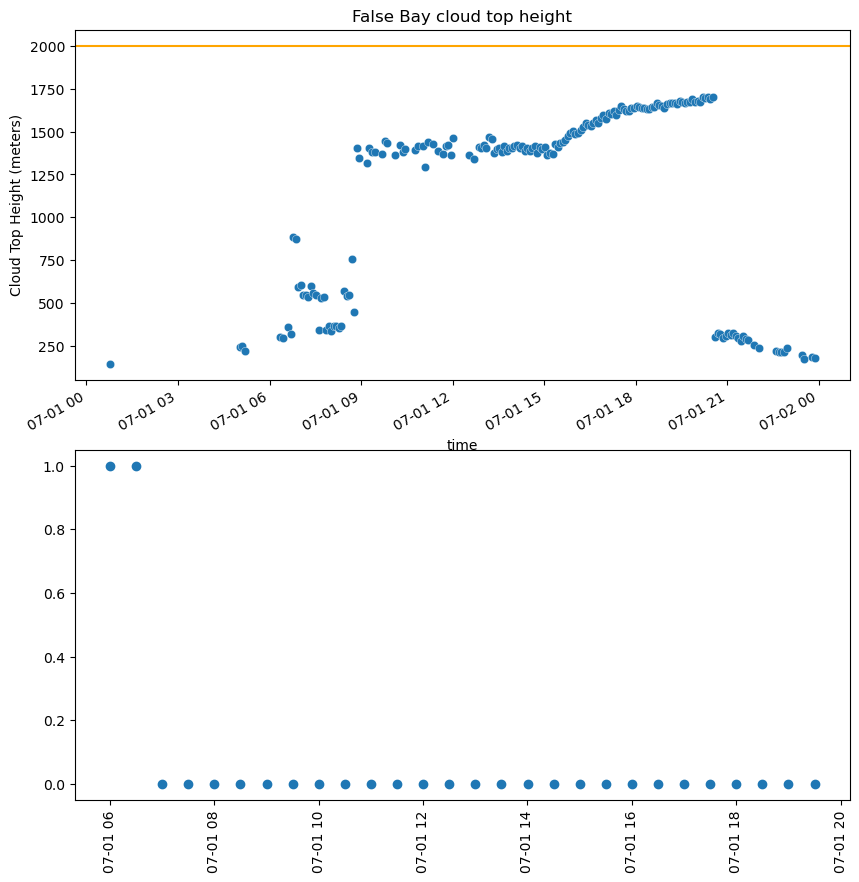

In [84]:
# Old code
fig, ax = plt.subplots(ncols=1, nrows=2, figsize = (10, 10))

falsebay_timeseries.sel(time = slice('July 1, 2022', 'July 1, 2022')).plot.scatter('time', linewidths=0.25, ax = ax[0])
ax[0].set_title('False Bay cloud top height')
ax[0].set_ylabel('Cloud Top Height (meters)')
ax[0].axhline(2000, color='orange') # 2000 meters is the chosen threshold for low cloud and fog

test_df = fog_df['2022-07-01': '2022-07-01']
# fig.autofmt_xdate()
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].locator_params(axis='x', nbins=10)
ax[1].scatter(test_df.index, test_df['Predicted label'])